# Denoising filter testing
## required libaries

In [1]:
import os, time, cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy.ndimage import median_filter
from skimage.draw import line as skidline
import functions as f
##remove root windows
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

home_dir = os.path.abspath("")

## load file

In [2]:
#filepath_noisy = filedialog.askopenfilename(title='Please select the image',filetypes=[("Tiff images", "*.tif;*.tiff")])
tiff_file  = home_dir + os.sep + '84d tiff.tif'
dataset = tifffile.imread(tiff_file)

In [3]:
z = dataset.shape[0]
h = dataset.shape[1]
w = dataset.shape[2]
print( "Dimensions: z = {:d}, h = {:d}, w = {:d} [px]".format(z, h, w) )


Dimensions: z = 1510, h = 1905, w = 1908 [px]


## Show the loaded images

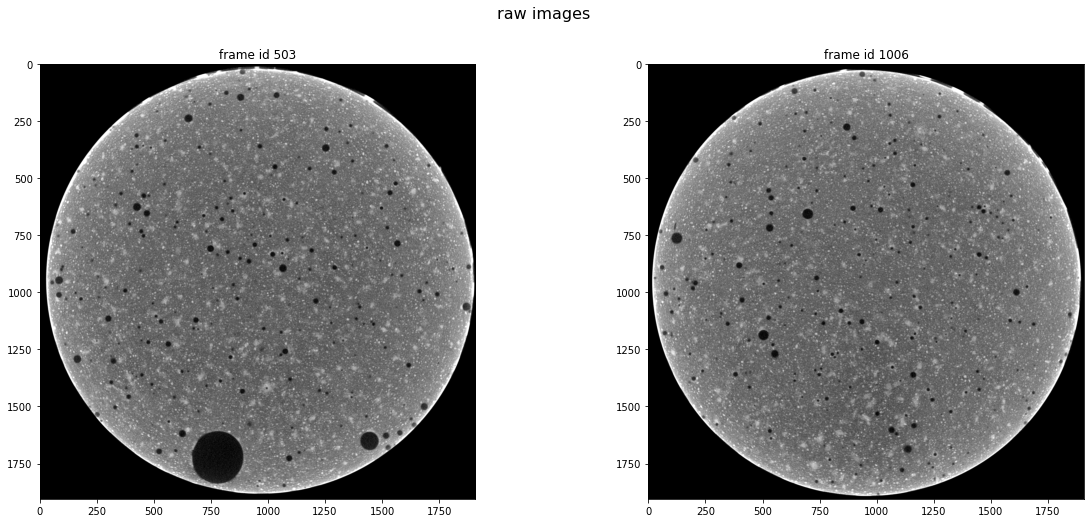

In [4]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
fig.suptitle('raw images', fontsize=16)

ax[0].imshow(dataset[int(z/3)], cmap='gray')
ax[0].set_title( "frame id {:d}".format(int(z/3)) )

ax[1].imshow(dataset[int(z/3*2)], cmap='gray')
ax[1].set_title( "frame id {:d}".format(int(z/3*2)) )

plt.show()

## process the main circle and the inner pores

In [5]:
slice	= dataset[int(z/3*2)]
thresh_v1 = 20
thresh_v2 = 70

blur = cv2.GaussianBlur(slice,(11,11),0)
ret,thresh1 = cv2.threshold( blur, thresh_v1, 255, cv2.THRESH_BINARY_INV )
ret,thresh2 = cv2.threshold( blur, thresh_v2, 255, cv2.THRESH_BINARY_INV )

edges = cv2.bitwise_not(thresh1)
#edges = cv2.Canny(blur,thresh,thresh*2)
contour, hierarchy = cv2.findContours( edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
for cnt in contour:
    cv2.drawContours(edges,[cnt],0,255,-1)
main_circle = cv2.bitwise_not(edges)

inner_pores = (thresh2-main_circle)/255

median = np.median( slice )

removed_pores = slice * np.logical_not(inner_pores) + inner_pores * median

## get center point

In [6]:
#cnts = cv2.findContours( cv2.bitwise_not(main_circle), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
#cnts = imutils.grab_contours(cnts)

M = cv2.moments(edges)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print( cX, cY )
cv2.circle(main_circle, (cX, cY), 3, (255, 255, 255), -1)

954 956


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

## show images

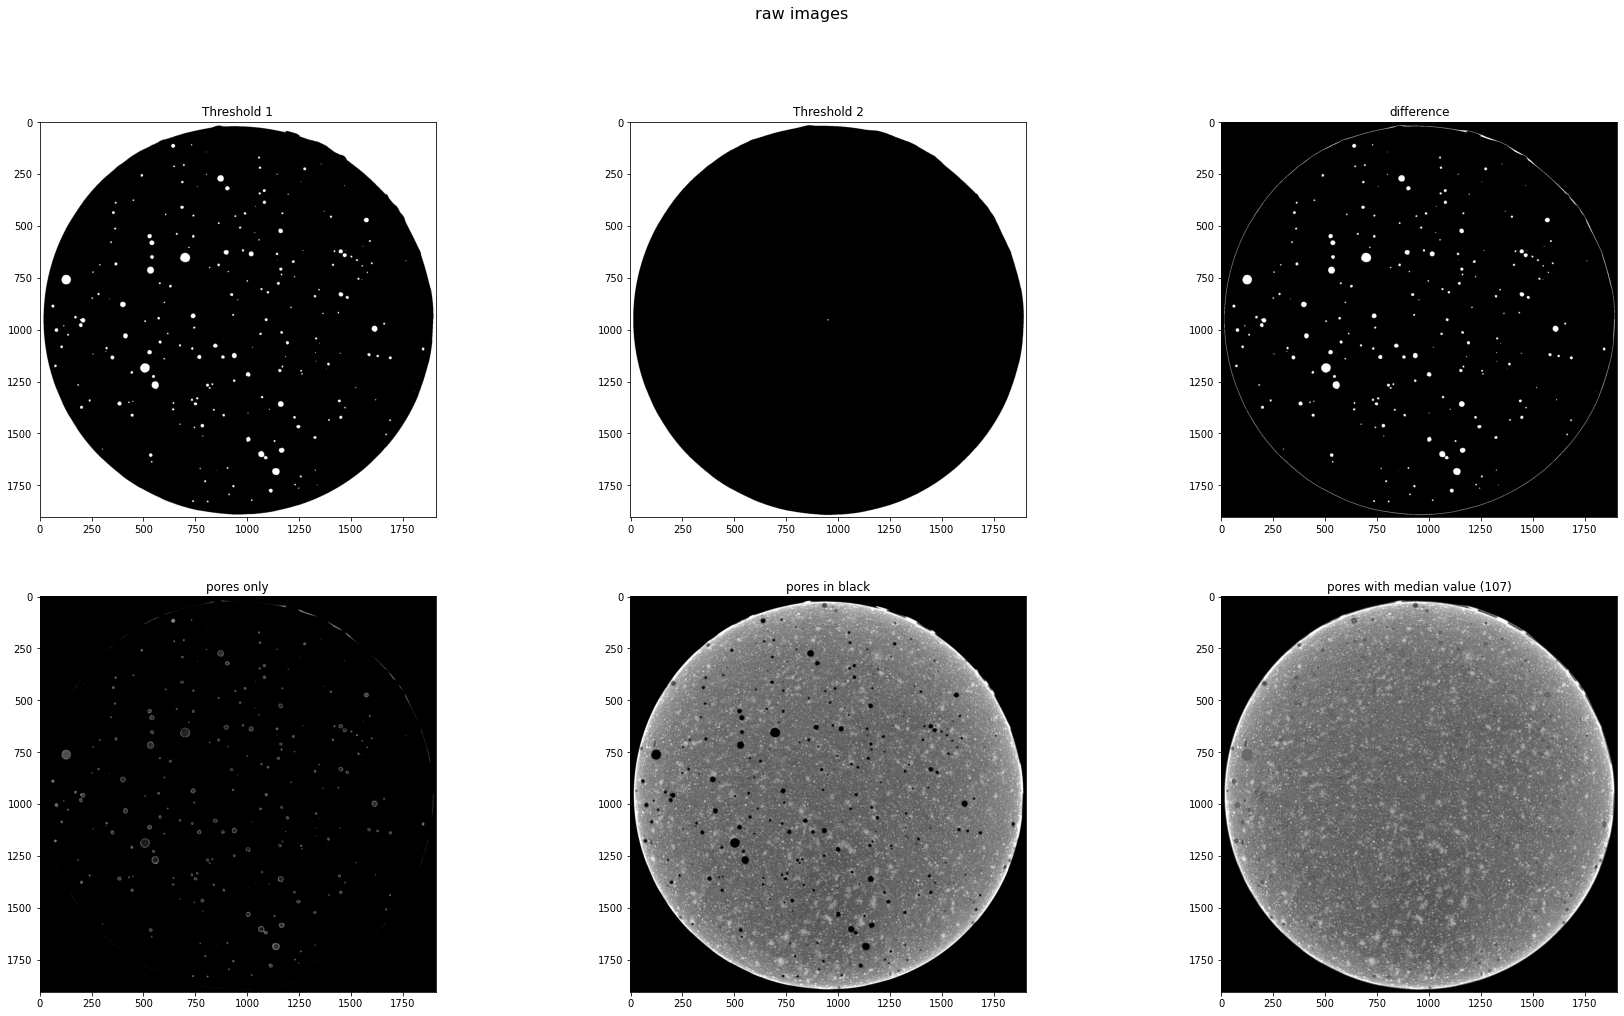

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(30, 16))
fig.suptitle('raw images', fontsize=16)

ax[0, 0].imshow( thresh2, cmap='gray' )
ax[0, 0].set_title( "Threshold 1" )

ax[0, 1].imshow( main_circle, cmap='gray')
ax[0, 1].set_title( "Threshold 2" )

ax[0, 2].imshow( inner_pores*np.median( dataset[int(z/3*2)] ), cmap='gray' )
ax[0, 2].set_title( "difference" )

ax[1, 0].imshow( slice * inner_pores, cmap='gray' )
ax[1, 0].set_title( "pores only" )

ax[1, 1].imshow( slice * np.logical_not(inner_pores), cmap='gray' )
ax[1, 1].set_title( "pores in black" )

ax[1, 2].imshow( removed_pores , cmap='gray' )
ax[1, 2].set_title( "pores with median value ({:.0f})".format(median) )

plt.show()
print()

In [8]:
def createLineIterator(P1, P2, img):
	"""
	Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

	Parameters:
		-P1: a numpy array that consists of the coordinate of the first point (x,y)
		-P2: a numpy array that consists of the coordinate of the second point (x,y)
		-img: the image being processed

	Returns:
		-it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
	"""
	#define local variables for readability
	imageH = img.shape[0]
	imageW = img.shape[1]
	P1X = P1[0]
	P1Y = P1[1]
	P2X = P2[0]
	P2Y = P2[1]

	#difference and absolute difference between points
	#used to calculate slope and relative location between points
	dX = P2X - P1X
	dY = P2Y - P1Y
	dXa = np.abs(dX)
	dYa = np.abs(dY)

	#predefine numpy array for output based on distance between points
	itbuffer = np.empty(shape=(np.maximum(dYa,dXa),2),dtype=np.uint16)
	itbuffer.fill(np.nan)
	print('-',len(itbuffer))

	#Obtain coordinates along the line using a form of Bresenham's algorithm
	negY = P1Y > P2Y
	negX = P1X > P2X
	if P1X == P2X: #vertical line segment
		itbuffer[:,0] = P1X
		if negY:
			itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
		else:
			itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
	elif P1Y == P2Y: #horizontal line segment
		itbuffer[:,1] = P1Y
		if negX:
			itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
		else:
			itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
	else: #diagonal line segment
		steepSlope = dYa > dXa
		if steepSlope:
			slope = dX.astype(np.float32)/dY.astype(np.float32)
			if negY:
				itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
			else:
				itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
			itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(int) + P1X
		else:
			slope = dY.astype(np.float32)/dX.astype(np.float32)
			if negX:
				itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
			else:
				itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
			itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(int) + P1Y

	#Remove points outside of image
	colX = itbuffer[:,0]
	colY = itbuffer[:,1]
	itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

	valbuffer = np.empty(shape=(len(itbuffer),1),dtype=np.float32)
	valbuffer.fill(np.nan)
	print(len(itbuffer), len(valbuffer))
	#Get intensities from img ndarray
	valbuffer[:,0] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

	return valbuffer, itbuffer

In [9]:
angle_in_deg = 0.5
median_blur_kernel = 1
min_length = np.array( [cY, h-cY, cX, w-cX] ).min()
values = np.empty( shape=(int(360/angle_in_deg), min_length), dtype=np.uint8)
"""
print(min_length)

def get_linepnts(p0, p1, img):
	p0, p1 = np.array(p0).flatten(), np.array(p1).flatten()
	l0 = np.array(list(zip(*skidline(p0[0],p0[1], p1[0],p1[1]))))
	#if p0/p1 are in (x,y) format, then this needs to be swapped for retrieval:
	return img[l0[:,1]-1, l0[:,0]-1]
    
line_length = []
max_pos = []
for i in range(int(360/angle_in_deg)):
	a	= np.deg2rad( i*angle_in_deg )
	Xi	= ( min_length * np.cos(a) + cX ).astype(int)
	Yi	= ( min_length * np.sin(a) + cY ).astype(int)
	# get values along two points
	v = get_linepnts((cX, cY), (Xi, Yi), removed_pores)
	line_length.append(len(v))
	# resize the line length in px
	v = cv2.resize( v, (1, min_length), interpolation = cv2.INTER_LINEAR ).astype( np.uint8 )
	values[i] = cv2.medianBlur(v, median_blur_kernel).flatten()
	max_pos.append(np.argmax(values[i]))
	
mean_values = (values.sum(0)/int(360/angle_in_deg)).astype(np.uint8)
max_pos = np.array(max_pos).astype(np.uint8)
max_pos = max_pos-np.mean(max_pos)"""

'\nprint(min_length)\n\ndef get_linepnts(p0, p1, img):\n\tp0, p1 = np.array(p0).flatten(), np.array(p1).flatten()\n\tl0 = np.array(list(zip(*skidline(p0[0],p0[1], p1[0],p1[1]))))\n\t#if p0/p1 are in (x,y) format, then this needs to be swapped for retrieval:\n\treturn img[l0[:,1]-1, l0[:,0]-1]\n    \nline_length = []\nmax_pos = []\nfor i in range(int(360/angle_in_deg)):\n\ta\t= np.deg2rad( i*angle_in_deg )\n\tXi\t= ( min_length * np.cos(a) + cX ).astype(int)\n\tYi\t= ( min_length * np.sin(a) + cY ).astype(int)\n\t# get values along two points\n\tv = get_linepnts((cX, cY), (Xi, Yi), removed_pores)\n\tline_length.append(len(v))\n\t# resize the line length in px\n\tv = cv2.resize( v, (1, min_length), interpolation = cv2.INTER_LINEAR ).astype( np.uint8 )\n\tvalues[i] = cv2.medianBlur(v, median_blur_kernel).flatten()\n\tmax_pos.append(np.argmax(values[i]))\n\t\nmean_values = (values.sum(0)/int(360/angle_in_deg)).astype(np.uint8)\nmax_pos = np.array(max_pos).astype(np.uint8)\nmax_pos = max_po

In [10]:
"""fig, ax = plt.subplots(1,2, figsize=(20, 8))
fig.suptitle('raw images', fontsize=16)
ax[0].imshow(removed_pores, cmap='gray')
ax[0].set_title( "removed pores" )
ax[1].imshow(values, cmap='gray')
ax[1].set_title( "unfolded circle" )
plt.show()

# show the mean grey value of the circle radius
plt.plot(range(min_length), mean_values)
plt.xlim((0, min_length))
plt.show()

#plt.plot(range(len(line_length)), np.array(line_length))
#plt.show()

#show uncircularity
plt.plot(range(len(max_pos)), median_filter(max_pos,25 ) )
plt.xlim((0, len(max_pos)))
plt.show()"""

'fig, ax = plt.subplots(1,2, figsize=(20, 8))\nfig.suptitle(\'raw images\', fontsize=16)\nax[0].imshow(removed_pores, cmap=\'gray\')\nax[0].set_title( "removed pores" )\nax[1].imshow(values, cmap=\'gray\')\nax[1].set_title( "unfolded circle" )\nplt.show()\n\n# show the mean grey value of the circle radius\nplt.plot(range(min_length), mean_values)\nplt.xlim((0, min_length))\nplt.show()\n\n#plt.plot(range(len(line_length)), np.array(line_length))\n#plt.show()\n\n#show uncircularity\nplt.plot(range(len(max_pos)), median_filter(max_pos,25 ) )\nplt.xlim((0, len(max_pos)))\nplt.show()'

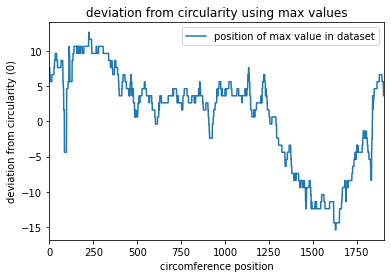

212 [102 102 100 ...   0   0   0]


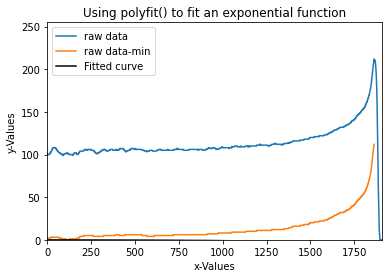

In [27]:
polar_image = cv2.linearPolar(removed_pores,(cX, cY), min_length, cv2.WARP_FILL_OUTLIERS)
mean_values = (values.sum(0)/len(polar_image)).astype(np.uint8)

median_blur_kernel = 21
max_pos = []

for i in range(len(polar_image)):
	max_pos.append(np.argmax(polar_image[i]))
	polar_image[i] = cv2.medianBlur(polar_image[i].astype(np.uint8), median_blur_kernel).flatten()

max_pos = np.array(max_pos).astype(np.uint8)
max_pos = max_pos-np.mean(max_pos)

#show uncircularity
ax = plt.axes()
#ax.set_yscale('log')
ax.plot(range(len(max_pos)), median_filter(max_pos,25 ) , label='position of max value in dataset')
ax.set_title('deviation from circularity using max values')
ax.set_ylabel('deviation from circularity (0)')
ax.set_xlim((0, len(max_pos)))
ax.set_xlabel('circomference position')
ax.legend()
plt.show()

mean_values = (polar_image.sum(0)/len(polar_image)).astype(np.uint8)

print(np.max(mean_values), mean_values)
np.savetxt("foo.csv", mean_values.astype(np.uint8), delimiter=",")

polar_background = np.empty(shape=polar_image.shape,dtype=int)
polar_background.fill(0)
for i in range(len(polar_image)):
	polar_background[i] = mean_values

max_pos = np.argmax(mean_values)+2


mean_val_to_max = mean_values[0:max_pos]
mean_val_to_max = cv2.medianBlur(mean_val_to_max, 81).astype(np.uint8).flatten()
mean_val_to_max = mean_val_to_max.astype(np.float64) - np.min(mean_val_to_max)+0.00000000001

p = np.polyfit(range(max_pos), np.log(mean_val_to_max), 1)


#y_fitted = np.exp(p[1]) * np.exp(p[0] * range(max_pos))
y_fitted = np.tanh(p[1]) * np.exp(p[0] * range(max_pos))

ax = plt.axes()
#ax.set_yscale('log')
ax.plot(range(len(mean_values)), mean_values, label='raw data')
ax.plot(range(max_pos), mean_val_to_max, label='raw data-min')
ax.plot(range(max_pos), y_fitted, 'k', label='Fitted curve')
ax.set_title('Using polyfit() to fit an exponential function')
ax.set_ylabel('y-Values')
ax.set_ylim(0, 255)
ax.set_xlim((0, len(mean_values)))
ax.set_xlabel('x-Values')
ax.legend()
plt.show()


polar_background_fit = np.empty(shape=polar_image.shape,dtype=int)
polar_background_fit.fill(0)
for i in range(len(polar_image)):
	for j,v in enumerate(y_fitted.astype(np.uint8)):
		polar_background_fit[i][j] = v

(1905, 1908)
(1905, 1865)


Text(0.5, 1.0, 'removed background')

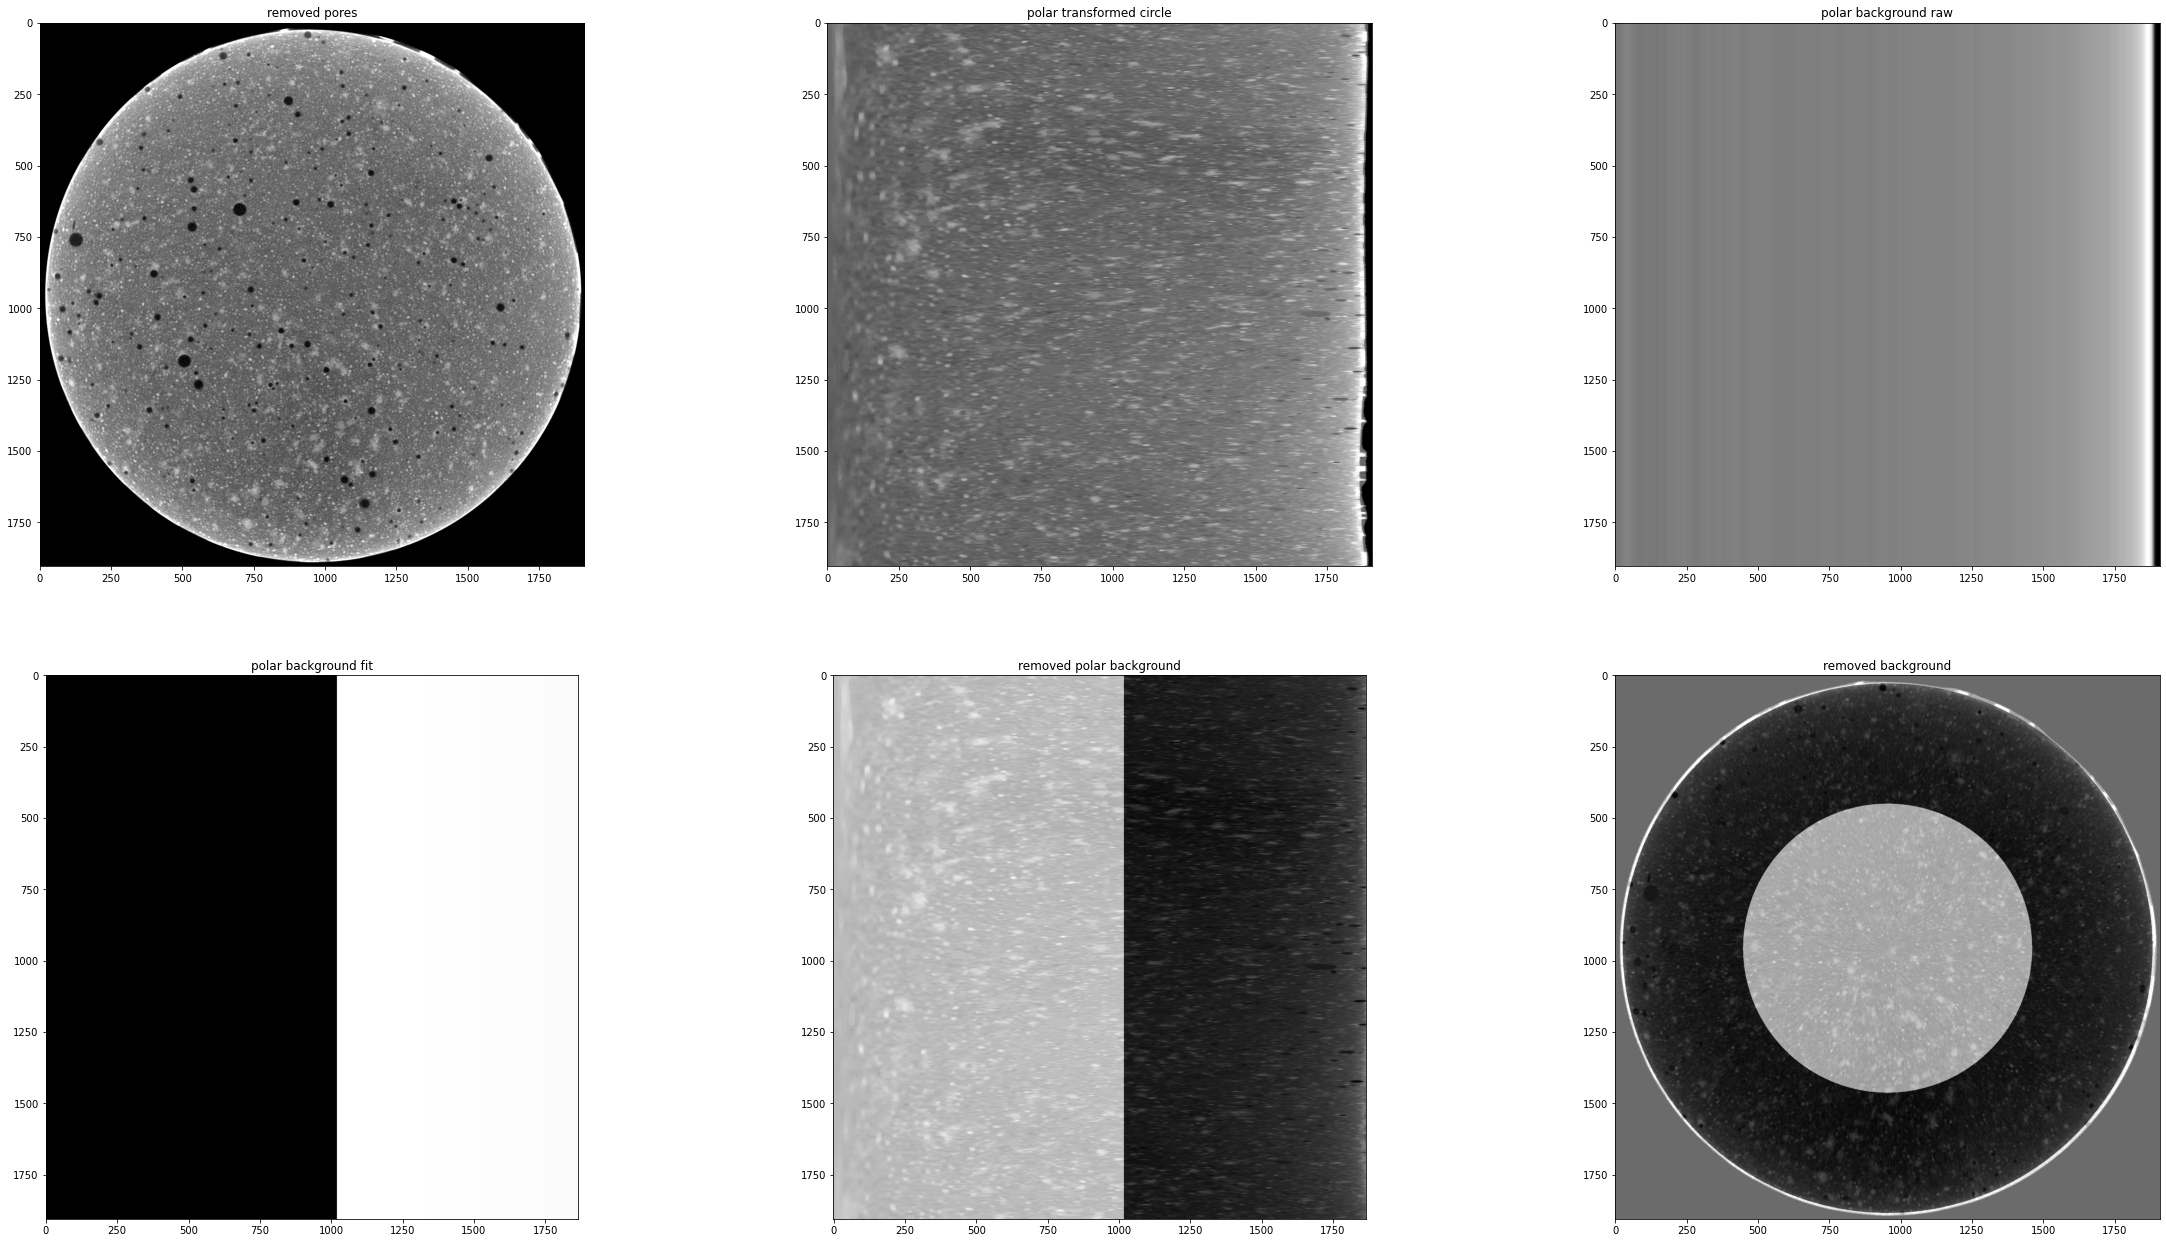

In [25]:
print(polar_background_fit.shape)
print(polar_background_fit[:, 0:max_pos].shape)

fixed_image = (polar_image-polar_background_fit)
unpolar = cv2.linearPolar(fixed_image,(cX, cY), min_length, cv2.WARP_INVERSE_MAP)

fig, ax = plt.subplots(2,3, figsize=(40,22))
#fig.suptitle( "raw images", fontsize=16 )
ax[0,0].imshow( slice, cmap='gray' )
ax[0,0].set_title( "removed pores" )
ax[0,1].imshow( polar_image, cmap='gray' )
ax[0,1].set_title( "polar transformed circle" )
ax[0,2].imshow( polar_background, cmap='gray' )
ax[0,2].set_title( "polar background raw" )
ax[1,0].imshow( polar_background_fit[:, 0:max_pos], cmap='gray' )
ax[1,0].set_title( "polar background fit" )
ax[1,1].imshow( fixed_image[:, 0:max_pos], cmap='gray' )
ax[1,1].set_title( "removed polar background" )
ax[1,2].imshow( unpolar, cmap='gray' )
ax[1,2].set_title( "removed background" )